In [ ]:
import os
import json
import argparse
import pandas as pd
from pymongo import MongoClient
from reportparse.reader.base import BaseReader
from reportparse.annotator.base import BaseAnnotator
from reportparse.util.settings import LAYOUT_NAMES, LEVEL_NAMES
import matplotlib.pyplot as plt
import seaborn as sns
import argparse


# parser = argparse.ArgumentParser(description="Process and analyze climate-related text from a PDF.")
# parser.add_argument("--input", type=str, default="./reportparse/asset/example.pdf", help="Path to input PDF file.")
# parser.add_argument("--output", type=str, default="./cli_results", help="Directory to save output files.")

# args = parser.parse_args()
out= "./cli_results"
os.makedirs(out, exist_ok=True)
inp ="./reportparse/asset/example.pdf"

reader = BaseReader.by_name("pymupdf")()

document = reader.read(input_path=inp)

document = BaseAnnotator.by_name("climate")().annotate(document=document)
document = BaseAnnotator.by_name("climate_commitment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_specificity")().annotate(document=document)

json_output_path = os.path.join(out, os.path.basename(inp) + ".json")
document.save(json_output_path)

df = document.to_dataframe(level="block")
df_2 = document.to_dataframe(level="page")

print(df)

# # eda
print(df.describe())
print()

print(df.info())
print()

print(df.head())
print()

print(df.tail())
print()

print(df.columns)
print()

print(df.index)
print()

climate_df = df[df["climate"] == "yes"]

cti_df = climate_df.groupby("page_id").apply(
    lambda x: pd.Series({
        "commit_total": (x["climate_commitment"] == "yes").sum(),
        "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
    })
)

# Calculate CTI
cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
cti_df["CTI"].fillna(0, inplace=True)

cti_df.reset_index(inplace=True)

print(cti_df)

# for the whole document
total_commit = (climate_df["climate_commitment"] == "yes").sum()
total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

cti_results = {
    "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
    "overall_cti": overall_cti
}
input_base = os.path.basename(inp)
output_path = f"./cli_results/{input_base}_cti_scrores.json"

with open(output_path, "w") as f:
    json.dump(cti_results, f, indent=4)

print(f"CTI scores saved to {output_path}")


page_ids = list(cti_results["page_cti_scores"].keys())
page_scores = list(cti_results["page_cti_scores"].values())

plt.figure(figsize=(12, 6))

sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

plt.xlabel("Page ID")
plt.ylabel("CTI Score")
plt.title("Cheap Talk Index (CTI) per Page")
plt.xticks(rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

# save plot in the same dir
plt.savefig(f"./cli_results/{input_base}_cti_plot.png")


NameError: name 'args' is not defined

In [ ]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq

logger = getLogger(__name__)


document = Document.from_json_file('example.pdf.json')
df = document.to_dataframe(level='page')
print(df)
print()
print(df.columns)

print()
# print first pass chroma result and web rag result for page 1
page_1 = document.pages[0]
# print(page_1.get_annotation("chroma"))
# print(page_1.get_annotation("web_rag"))

# print the same from df
# print(df.loc[0, "chroma_result"])

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   
5  page_idx_5         5  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Potential greenwashing claim: Hitachi's carbon...   
1  Potential greenwashing claim: Improve water us...   
2  Potential greenwashing claim: Achieving a Deca...   
3  Potentia

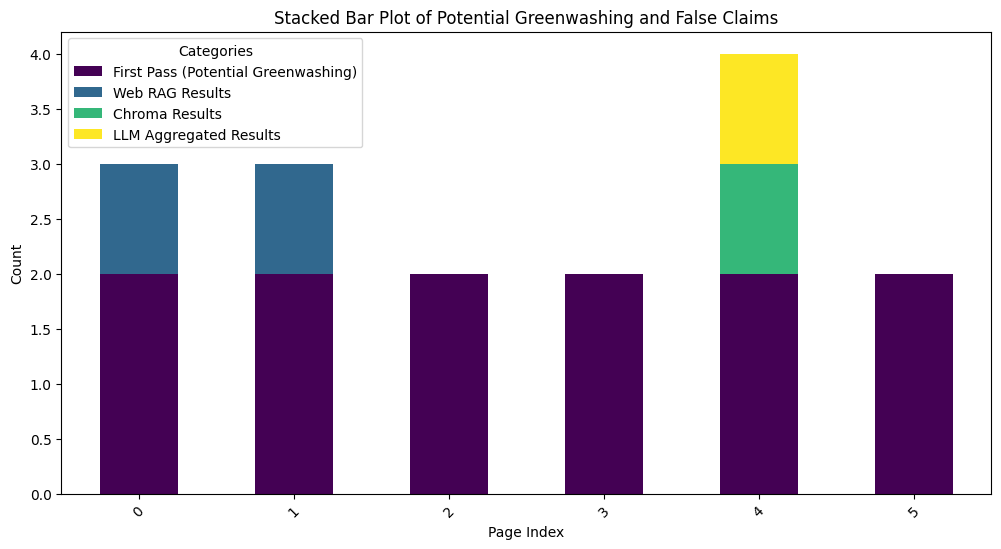

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

first_pass_count = df["First pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

# Define function to count occurrences of "PARTIALLY FALSE" and "FALSE"
def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

web_rag_count = count_false_statements(["web_rag_result", "web_rag_result_2"], df)
chroma_count = count_false_statements(["chroma_result", "chroma_result_2"], df)
llm_agg_count = count_false_statements(["aggregator_result", "aggregator_result_2"], df)

plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()


## Confusion matrix 

In [ ]:
import pandas as pd
#delete null columns
df = pd.read_csv('experiment1_with_def.csv')
df = df.dropna(axis=1, how='all')
#prepate data for join
df2 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df2['Type'] = df2['Type'].map(lambda x: 'GREENWASHING' if x == 'greenwash' else 'NOT_GREENWASHING')
#join the dataset
df['ground_truth'] = df['id'].map(df2['Type'])
#df.to_csv('experiment2_with_def.csv', index=False)


In [14]:
#rename label columns
df = pd.read_csv('final_aggregation_without_intermediate_steps.csv')
y_pred = 'aggregator_label'
df = df[df[y_pred].notnull()]
df.loc[df[y_pred].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), y_pred] = 'GREENWASHING'

#measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
overall_accuracy = accuracy_score(df[y_pred], df['ground_truth'])
print("Overall Accuracy:", np.round(np.round(overall_accuracy,3)*100,3), "%")


labels = df['ground_truth'].unique()

for label in labels:
    correct = ((df[y_pred] == df['ground_truth']) & (df['ground_truth'] == label)).sum()
    total = (df['ground_truth'] == label).sum()
    label_accuracy = (correct / total * 100) if total else 0
    print(f"Accuracy for {label}: {label_accuracy:.2f}%")
    

Overall Accuracy: 53.7 %
Accuracy for GREENWASHING: 52.08%
Accuracy for NOT_GREENWASHING: 66.67%


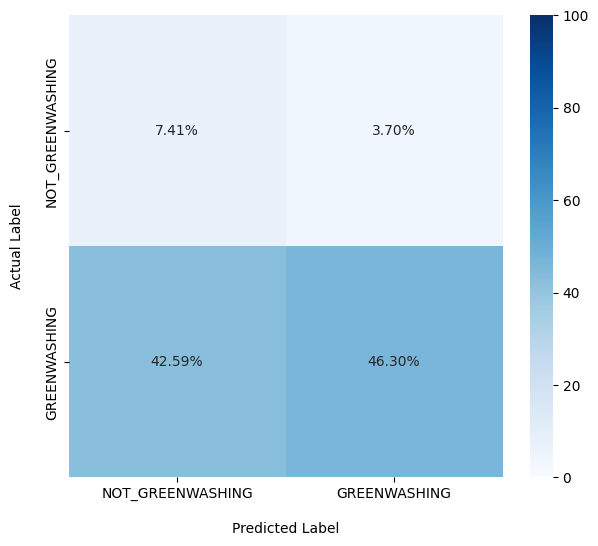

In [15]:
# Calculate TP, FP, TN, FN as before
TP = ((df[y_pred] == 'GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()
FP = ((df[y_pred] == 'GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
TN = ((df[y_pred] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
FN = ((df[y_pred] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix_counts = np.array([[TN, FP],
                               [FN, TP]])

# Convert to percentages relative to total samples
total = conf_matrix_counts.sum()
conf_matrix_percent = (conf_matrix_counts / total) * 100

# Create formatted annotations with '%' symbol
annotations = np.array([["{:.2f}%".format(value) for value in row] for row in conf_matrix_percent])

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_percent,
            annot=annotations,
            fmt='',
            cmap='Blues',
            xticklabels=['NOT_GREENWASHING', 'GREENWASHING'],
            yticklabels=['NOT_GREENWASHING', 'GREENWASHING'],
            vmin=0, vmax=100)  # Force color bar scale from 0 to 100

plt.xlabel('Predicted Label', labelpad=15)
plt.ylabel('Actual Label', labelpad=15)
plt.savefig("poster_plots/confusion_matrix_percentages_2.pdf")
plt.show()


### Barplots with and without UNCLEAR label

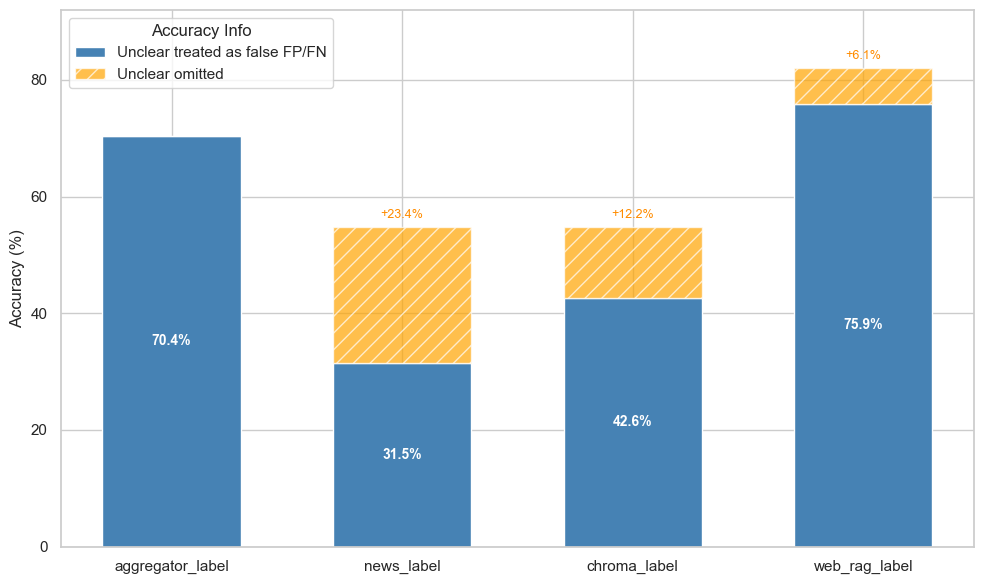

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')


# Step 2: Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Step 3: Collect scores
base_accuracies = []  # with UNCLEAR
deltas = []           # improvement after removing UNCLEAR

for col in y_pred:
    acc_with = accuracy_score(df['ground_truth'], df[col])
    df_filtered = df[df[col] != 'UNCLEAR']
    acc_without = accuracy_score(df_filtered['ground_truth'], df_filtered[col])
    
    base_accuracies.append(acc_with * 100)
    deltas.append((acc_without - acc_with) * 100)

# Step 4: Plot with highlighted difference
x = range(len(y_pred))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

# Base bars (with UNCLEAR)
bars = ax.bar(x, base_accuracies, width=width, color='steelblue', label='Unclear treated as false FP/FN')

# Difference bars (improvement)
ax.bar(x, deltas, width=width, bottom=base_accuracies, color='orange', alpha=0.7, hatch='//', label='Unclear omitted')

# Annotations
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    # Text inside the blue bar
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    # Text above the orange bar
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='darkorange')

# Styling
ax.set_xticks(list(x))
ax.set_xticklabels(y_pred)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_accuracies, deltas)]) + 10)
#ax.set_title("Accuracy by Label Source with Highlighted Improvement (No UNCLEAR)", fontsize=14, weight='bold')
ax.legend(title="Accuracy Info")

plt.tight_layout()
#plt.savefig("poster_plots/accuracy_by_label_source.pdf")
plt.show()


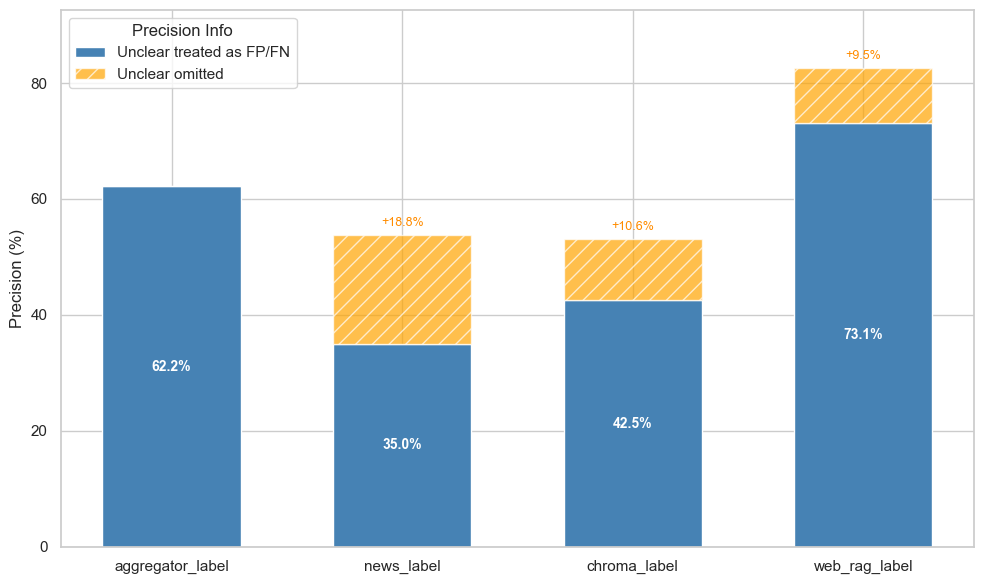

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom precision function with UNCLEAR handling
def precision_with_unclear(y_true, y_pred):
    """
    Calculate precision where UNCLEAR predictions are treated as:
      - FN if true label is GREENWASHING and prediction is UNCLEAR
      - FP if true label is NOT GREENWASHING and prediction is UNCLEAR
    """
    # Define binary labels for ground truth: GREENWASHING = 1, else 0
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]

    # Map predictions:
    # - GREENWASHING = 1
    # - NOT GREENWASHING = 0
    # - UNCLEAR -> handled as follows:
    #    - if y_true = 1 and y_pred=UNCLEAR: treat as FN -> means pred=0 (no greenwashing)
    #    - if y_true = 0 and y_pred=UNCLEAR: treat as FP -> means pred=1 (greenwashing)
    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            # If ground truth is positive, unclear means missed positive (FN), so pred = 0
            # If ground truth is negative, unclear means false alarm (FP), so pred = 1
            y_pred_bin.append(0 if t == 1 else 1)
        else:
            # treat any other label as NOT GREENWASHING
            y_pred_bin.append(0)

    # Calculate precision (for positive class = 1)
    return precision_score(y_true_bin, y_pred_bin, zero_division=0) * 100  # percentage

# Calculate precision scores with UNCLEAR included
base_precisions = []
# Also calculate precision without UNCLEAR (filter those rows out)
deltas = []

for col in y_pred:
    prec_with_unclear = precision_with_unclear(df['ground_truth'], df[col])
    
    df_filtered = df[df[col] != 'UNCLEAR']
    prec_without_unclear = precision_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100
    
    base_precisions.append(prec_with_unclear)
    deltas.append(prec_without_unclear - prec_with_unclear)

# Plotting
x = range(len(y_pred))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(x, base_precisions, width=width, color='steelblue', label='Unclear treated as FP/FN')
ax.bar(x, deltas, width=width, bottom=base_precisions, color='orange', alpha=0.7, hatch='//', label='Unclear omitted')

for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='darkorange')

ax.set_xticks(list(x))
ax.set_xticklabels(y_pred)
ax.set_ylabel("Precision (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_precisions, deltas)]) + 10)
ax.legend(title="Precision Info")

plt.tight_layout()
plt.savefig("poster_plots/precision_by_label_source.pdf")
plt.show()


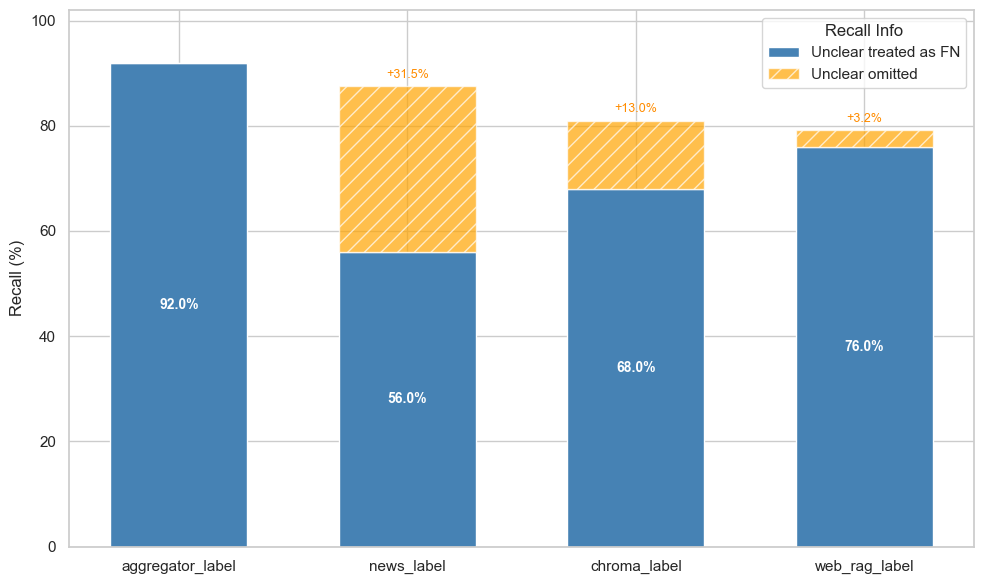

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom recall function with UNCLEAR handling
def recall_with_unclear(y_true, y_pred):
    """
    Calculate recall where UNCLEAR predictions are treated as:
      - FN if true label is GREENWASHING and prediction is UNCLEAR
      - TN if true label is NOT GREENWASHING and prediction is UNCLEAR
    """
    # Binary labels for ground truth: GREENWASHING=1, else 0
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]

    # Map predictions:
    # GREENWASHING = 1
    # NOT GREENWASHING = 0
    # UNCLEAR:
    #   if y_true=1 and pred=UNCLEAR -> FN (predict 0)
    #   if y_true=0 and pred=UNCLEAR -> TN (predict 0)
    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            y_pred_bin.append(0)  # always predict 0 on UNCLEAR for recall
        else:
            y_pred_bin.append(0)

    return recall_score(y_true_bin, y_pred_bin, zero_division=0) * 100  # percentage

# Calculate recall scores with UNCLEAR included
base_recalls = []
deltas = []

for col in y_pred:
    rec_with_unclear = recall_with_unclear(df['ground_truth'], df[col])
    
    df_filtered = df[df[col] != 'UNCLEAR']
    rec_without_unclear = recall_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100
    
    base_recalls.append(rec_with_unclear)
    deltas.append(rec_without_unclear - rec_with_unclear)

# Plotting
x = range(len(y_pred))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(x, base_recalls, width=width, color='steelblue', label='Unclear treated as FN')
ax.bar(x, deltas, width=width, bottom=base_recalls, color='orange', alpha=0.7, hatch='//', label='Unclear omitted')

for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='darkorange')

ax.set_xticks(list(x))
ax.set_xticklabels(y_pred)
ax.set_ylabel("Recall (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_recalls, deltas)]) + 10)
ax.legend(title="Recall Info")

plt.tight_layout()
plt.savefig("poster_plots/recall_by_label_source.pdf")
plt.show()


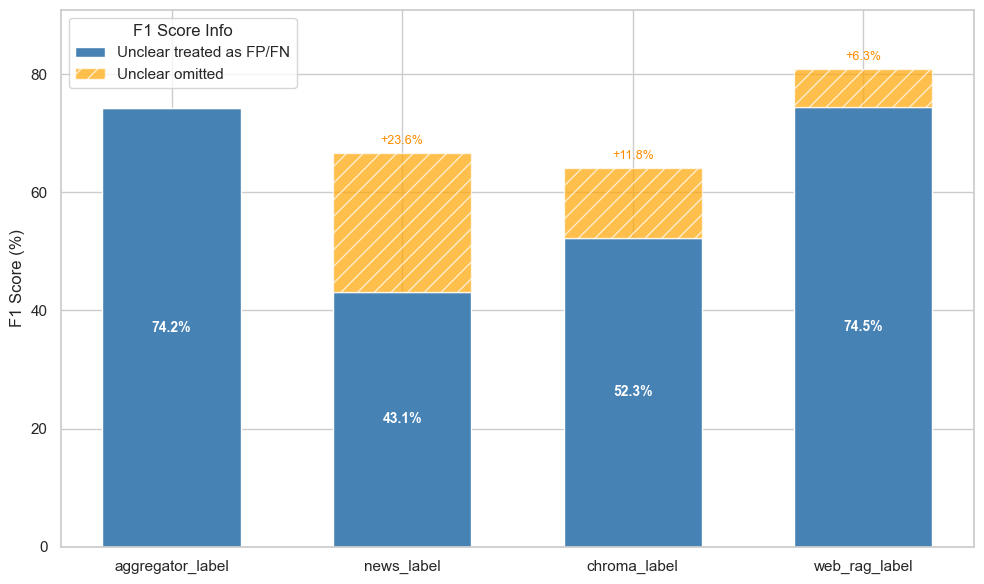

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom F1 function with UNCLEAR handling
def f1_with_unclear(y_true, y_pred):
    """
    Calculate F1 where UNCLEAR predictions are treated as:
      - FN if true label is GREENWASHING and prediction is UNCLEAR (pred=0)
      - FP if true label is NOT GREENWASHING and prediction is UNCLEAR (pred=1)
    """
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]

    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            y_pred_bin.append(0 if t == 1 else 1)
        else:
            y_pred_bin.append(0)

    return f1_score(y_true_bin, y_pred_bin, zero_division=0) * 100

# Calculate F1 scores with UNCLEAR included
base_f1s = []
deltas = []

for col in y_pred:
    f1_with = f1_with_unclear(df['ground_truth'], df[col])

    df_filtered = df[df[col] != 'UNCLEAR']
    f1_without = f1_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100

    base_f1s.append(f1_with)
    deltas.append(f1_without - f1_with)

# Plotting
x = range(len(y_pred))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(x, base_f1s, width=width, color='steelblue', label='Unclear treated as FP/FN')
ax.bar(x, deltas, width=width, bottom=base_f1s, color='orange', alpha=0.7, hatch='//', label='Unclear omitted')

for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='darkorange')

ax.set_xticks(list(x))
ax.set_xticklabels(y_pred)
ax.set_ylabel("F1 Score (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_f1s, deltas)]) + 10)
ax.legend(title="F1 Score Info")

plt.tight_layout()
plt.savefig("poster_plots/f1_by_label_source.pdf")
plt.show()


In [122]:
import pandas as pd
from collections import Counter

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

def confusion_counts(y_true, y_pred):
    """
    Returns counts of TP, FP, FN, TN with the custom UNCLEAR handling:
    - UNCLEAR predicted counts as:
      * FN if true label is GREENWASHING (missed positive)
      * FP if true label is NOT GREENWASHING (wrong positive)
    """
    counts = Counter({'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})

    for t, p in zip(y_true, y_pred):
        # Convert to binary
        t_bin = 1 if t == 'GREENWASHING' else 0
        
        # Handle prediction
        if p == 'GREENWASHING':
            p_bin = 1
        elif p == 'UNCLEAR':
            # UNCLEAR counts as FN if true positive, else FP
            if t_bin == 1:
                counts['FN'] += 1
                continue
            else:
                counts['FP'] += 1
                continue
        else:
            p_bin = 0
        
        # Increment counts
        if p_bin == 1 and t_bin == 1:
            counts['TP'] += 1
        elif p_bin == 1 and t_bin == 0:
            counts['FP'] += 1
        elif p_bin == 0 and t_bin == 1:
            counts['FN'] += 1
        elif p_bin == 0 and t_bin == 0:
            counts['TN'] += 1

    return counts

print("Confusion matrix counts with UNCLEAR included:")
for col in y_pred:
    counts = confusion_counts(df['ground_truth'], df[col])
    print(f"{col}: {dict(counts)}")

print("\nConfusion matrix counts with UNCLEAR removed:")
for col in y_pred:
    filtered_df = df[df[col] != 'UNCLEAR']
    y_true_bin = ['GREENWASHING' if x == 'GREENWASHING' else 'NOT GREENWASHING' for x in filtered_df['ground_truth']]
    y_pred_bin = filtered_df[col]

    counts = Counter({'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})
    for t, p in zip(y_true_bin, y_pred_bin):
        t_bin = 1 if t == 'GREENWASHING' else 0
        p_bin = 1 if p == 'GREENWASHING' else 0

        if p_bin == 1 and t_bin == 1:
            counts['TP'] += 1
        elif p_bin == 1 and t_bin == 0:
            counts['FP'] += 1
        elif p_bin == 0 and t_bin == 1:
            counts['FN'] += 1
        elif p_bin == 0 and t_bin == 0:
            counts['TN'] += 1

    print(f"{col}: {dict(counts)}")





Confusion matrix counts with UNCLEAR included:
aggregator_label: {'TP': 23, 'FP': 14, 'FN': 2, 'TN': 15}
news_label: {'TP': 14, 'FP': 26, 'FN': 11, 'TN': 3}
chroma_label: {'TP': 17, 'FP': 23, 'FN': 8, 'TN': 6}
web_rag_label: {'TP': 19, 'FP': 7, 'FN': 6, 'TN': 22}

Confusion matrix counts with UNCLEAR removed:
aggregator_label: {'TP': 23, 'FP': 14, 'FN': 2, 'TN': 15}
news_label: {'TP': 14, 'FP': 12, 'FN': 2, 'TN': 3}
chroma_label: {'TP': 17, 'FP': 15, 'FN': 4, 'TN': 6}
web_rag_label: {'TP': 19, 'FP': 4, 'FN': 5, 'TN': 22}


### Create a plot measuring performance with intermediate RAGs vs non indermediate RAGs

In [4]:
import pandas as pd
df = pd.read_csv('final_aggregation_without_intermediate_steps.csv')
df2 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df2['Type'] = df2['Type'].map(lambda x: 'GREENWASHING' if x == 'greenwash' else 'NOT_GREENWASHING')
#join the dataset
df['ground_truth'] = df['id'].map(df2['Type'])
#df.to_csv('final_aggregation_without_intermediate_steps.csv', index=False)

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Load the dataset
df = pd.read_csv('final_aggregation_without_intermediate_steps.csv')
# List of prediction columns to evaluate
y_pred_cols = ['aggregator_label']
# Ground truth column
y_true_col = 'ground_truth'
# Results storage
metrics_data = []
# Calculate metrics for each y_pred column
for col in y_pred_cols:
    if col not in df.columns:
        continue  # skip if column doesn't exist

    # Drop rows with null in either ground truth or y_pred
    temp_df = df[[y_true_col, col]].dropna()

    # Optional: normalize GREENWASHING TYPE labels (only for specific columns if needed)
    if col in y_pred_cols:
        temp_df.loc[temp_df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), col] = 'GREENWASHING'
        #temp_df = temp_df[temp_df[col] != 'UNCLEAR']
        
    y_true = temp_df[y_true_col]
    y_pred = temp_df[col]

 

    metrics_data.append({
        'Label Source': str(col + "_without_intermediate_RAGs"),
        'Metric': 'Accuracy',
        'Score': accuracy_score(y_true, y_pred) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_without_intermediate_RAGs"),
        'Metric': 'Precision',
        'Score': precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_without_intermediate_RAGs"),
        'Metric': 'Recall',
        'Score': recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_without_intermediate_RAGs"),
        'Metric': 'F1 Score',
        'Score': f1_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })







In [6]:
# Load the dataset
df = pd.read_csv('experiment1_with_def.csv')
# List of prediction columns to evaluate
y_pred_cols = ['aggregator_label']
# Ground truth column
y_true_col = 'ground_truth'
# Results storage
#metrics_data = []
# Calculate metrics for each y_pred column
for col in y_pred_cols:
    if col not in df.columns:
        continue  # skip if column doesn't exist

    # Drop rows with null in either ground truth or y_pred
    temp_df = df[[y_true_col, col]].dropna()

    # Optional: normalize GREENWASHING TYPE labels (only for specific columns if needed)
    if col in y_pred_cols:
        temp_df.loc[temp_df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), col] = 'GREENWASHING'
        temp_df2 = temp_df[temp_df[col] != 'UNCLEAR']
        
    y_true = temp_df[y_true_col]
    y_pred = temp_df[col]

    y_true2 = temp_df2[y_true_col]
    y_pred2 = temp_df2[col]

    metrics_data.append({
        'Label Source': str(col + "_with_intermediate_RAGs"),
        'Metric': 'Accuracy',
        'Score': accuracy_score(y_true, y_pred) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_with_intermediate_RAGs"),
        'Metric': 'Precision',
        'Score': precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_with_intermediate_RAGs"),
        'Metric': 'Recall',
        'Score': recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': str(col + "_with_intermediate_RAGs"),
        'Metric': 'F1 Score',
        'Score': f1_score(y_true, y_pred, average='macro', zero_division=0) * 100
    })



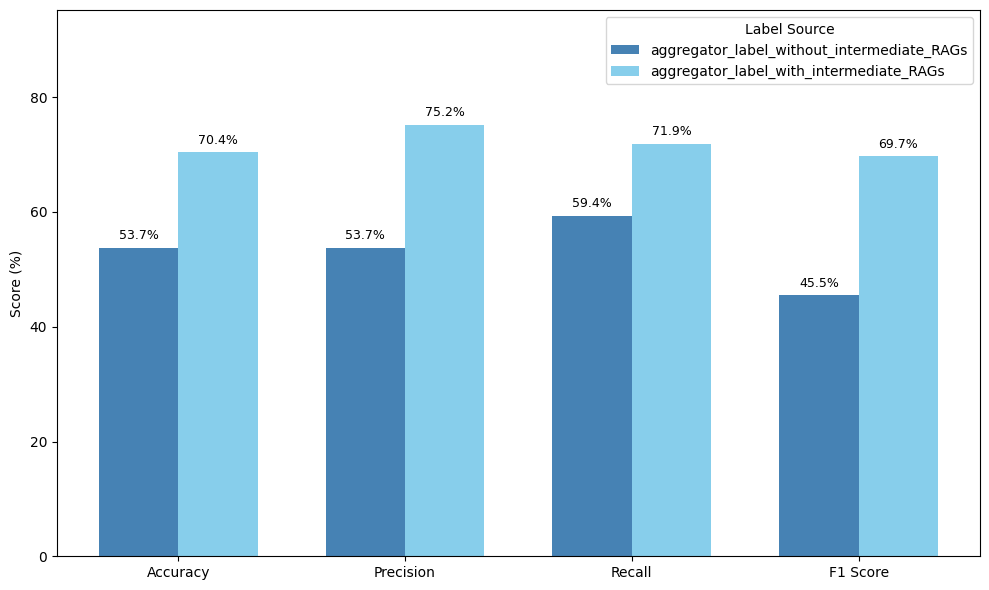

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume metrics_df is already defined
metrics_df = pd.DataFrame(metrics_data)
metric_order = ["Accuracy", "Precision", "Recall", "F1 Score"]
pivot_df = metrics_df.pivot(index="Metric", columns="Label Source", values="Score").loc[metric_order]

# Get the two label sources
cols = pivot_df.columns.tolist()
without_col = [c for c in cols if "without" in c][0]
with_col = [c for c in cols if "with" in c][0]

x = range(len(pivot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot both bars side by side
bar1 = ax.bar([i - width / 2 for i in x], pivot_df[without_col], width=width, label=without_col, color='steelblue')
bar2 = ax.bar([i + width / 2 for i in x], pivot_df[with_col], width=width, label=with_col, color='skyblue')

# Annotate values
for i in x:
    y1 = pivot_df.iloc[i][without_col]
    y2 = pivot_df.iloc[i][with_col]
    ax.text(i - width / 2, y1 + 1, f"{y1:.1f}%", ha='center', va='bottom', fontsize=9)
    ax.text(i + width / 2, y2 + 1, f"{y2:.1f}%", ha='center', va='bottom', fontsize=9)

# Styling
ax.set_xticks(list(x))
ax.set_xticklabels(metric_order)
ax.set_ylabel("Score (%)")
ax.set_ylim(0, max(pivot_df.max()) + 20)
#ax.set_title("Performance Comparison: With vs Without Intermediate RAGs", fontsize=14, weight='bold')
ax.legend(title="Label Source")

plt.tight_layout()
plt.savefig("poster_plots/performance_comparison.pdf")  # Save as PDF
plt.show()


## Creating barplots for the RAG pipelines

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Step 2: Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Step 3: Collect metrics
metrics_with = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
metrics_without = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}

for col in y_pred:
    # With UNCLEAR
    metrics_with['Accuracy'].append(accuracy_score(df['ground_truth'], df[col]) * 100)
    metrics_with['Precision'].append(precision_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_with['Recall'].append(recall_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_with['F1'].append(f1_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)

    # Without UNCLEAR
    df_filtered = df[df[col] != 'UNCLEAR']
    metrics_without['Accuracy'].append(accuracy_score(df_filtered['ground_truth'], df_filtered[col]) * 100)
    metrics_without['Precision'].append(precision_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_without['Recall'].append(recall_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_without['F1'].append(f1_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)

# Step 4: Plot grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
n_models = len(y_pred)
n_metrics = len(metrics)
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

# Plot for each metric
for i, metric in enumerate(metrics):
    offset = i - (n_metrics - 1) / 2  # spacing around model index
    x = [j + offset * width for j in range(n_models)]

    ax.bar(x, metrics_with[metric], width=width, label=f'{metric} (with UNCLEAR)', alpha=0.6)
    ax.bar(x, metrics_without[metric], width=width, label=f'{metric} (without UNCLEAR)', alpha=0.9)

    # Annotate top values
    for j in range(n_models):
        ax.text(x[j], metrics_without[metric][j] + 1, f"{metrics_without[metric][j]:.1f}%", ha='center', va='bottom', fontsize=8)

# Styling
ax.set_xticks(range(n_models))
ax.set_xticklabels(y_pred)
ax.set_ylabel("Score (%)")
ax.set_ylim(0, 110)
ax.set_title("Evaluation Metrics per Label Source (With vs Without UNCLEAR)", fontsize=14, weight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].